In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', 'dfe656166323461ea292c237b104b5ac')

Or, if you're comfortable at the command line, you can set it in your terminal with:

    export AZURE_SEARCH_KEY=your_key_here

and then restart Jupyter Notebook, and use the above line without editing it.

Once you've set `key`, you can use `search_images_bing`. This function is provided by the small `utils` class included with the notebooks online. If you're not sure where a function is defined, you can just type it in your notebook to find out:

In [5]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [6]:
results = search_images_bing(key, 'tucano')
ims = results.attrgot('contentUrl')
len(ims)

150

In [9]:
bear_types = 'Tucano-de-peito-amarelo','Tucano-chocó','Tucano-de-bico-preto','Tucano-de-mandíbula-preta','Tucano-de-bico-verde'
path = Path('tucanos')

In [10]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} tucanos')
        download_images(dest, urls=results.attrgot('contentUrl'))

Our folder has image files, as we'd expect:

In [11]:
fns = get_image_files(path)
fns

(#737) [Path('tucanos/Tucano-chocó/00000047.jpg'),Path('tucanos/Tucano-chocó/00000055.jpg'),Path('tucanos/Tucano-chocó/00000098.png'),Path('tucanos/Tucano-chocó/00000107.jpg'),Path('tucanos/Tucano-chocó/00000036.jpg'),Path('tucanos/Tucano-chocó/00000030.jpg'),Path('tucanos/Tucano-chocó/00000097.jpg'),Path('tucanos/Tucano-chocó/00000148.jpg'),Path('tucanos/Tucano-chocó/00000110.jpg'),Path('tucanos/Tucano-chocó/00000029.jpg')...]

In [14]:
failed = verify_images(fns)
failed

(#1) [Path('tucanos/Tucano-de-bico-preto/00000046.jpg')]

To remove all the failed images, you can use `unlink` on each of them. Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. This calls the passed function on each element of the collection:

### Sidebar: Getting Help in Jupyter Notebooks

In [16]:
tucanos = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [17]:
dls = tucanos.dataloaders(path)

A `DataLoaders` includes validation and training `DataLoader`s. `DataLoader` is a class that provides batches of a few items at a time to the GPU. We'll be learning a lot more about this class in the next chapter. When you loop through a `DataLoader` fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the `show_batch` method on a `DataLoader`:

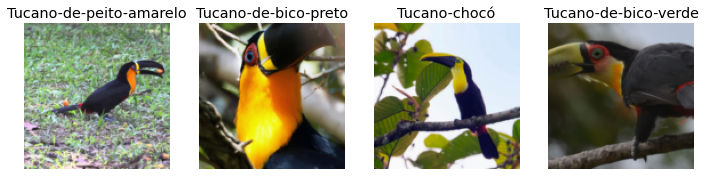

In [18]:
dls.valid.show_batch(max_n=4, nrows=1)

By default `Resize` *crops* the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:

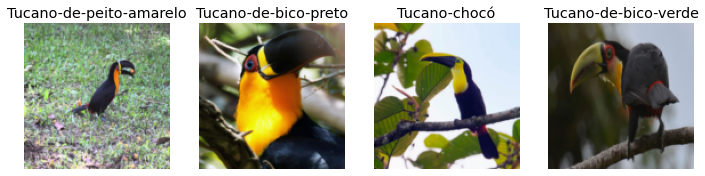

In [19]:
tucanos = tucanos.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = tucanos.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

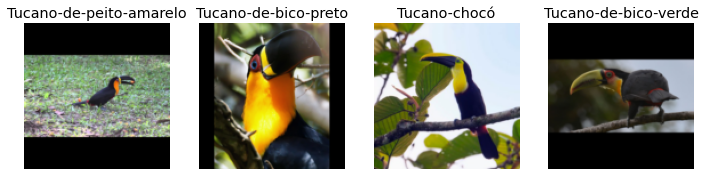

In [20]:
tucanos = tucanos.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = tucanos.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

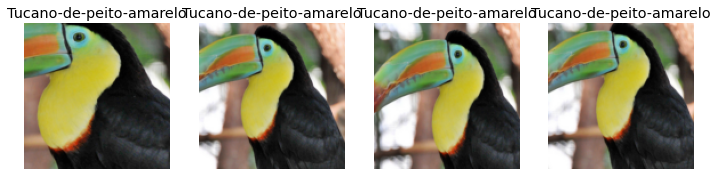

In [21]:
tucanos = tucanos.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = tucanos.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

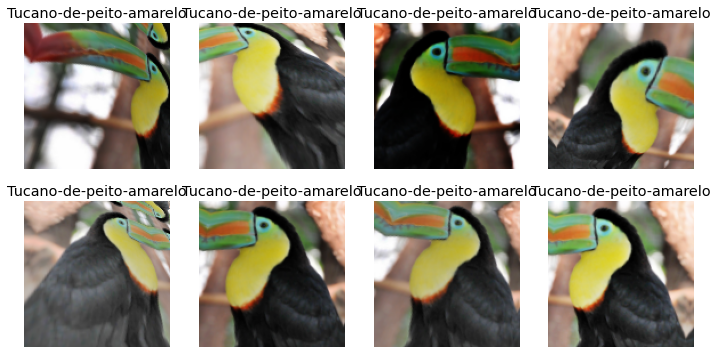

In [22]:
tucanos = tucanos.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = tucanos.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Now that we have assembled our data in a format fit for model training, let's actually train an image classifier using it.

## Training Your Model, and Using It to Clean Your Data

Time to use the same lines of code as in <<chapter_intro>> to train our bear classifier.

We don't have a lot of data for our problem (150 pictures of each sort of bear at most), so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default `aug_transforms`:

In [23]:
tucanos = tucanos.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = tucanos.dataloaders(path)

We can now create our `Learner` and fine-tune it in the usual way:

In [24]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.440573,1.954835,0.612245,00:10


epoch,train_loss,valid_loss,error_rate,time
0,1.889009,1.866322,0.551020,00:11
1,1.787441,1.887102,0.530612,00:11
2,1.602678,1.912213,0.503401,00:11
3,1.489055,1.891479,0.482993,00:11


Now let's see whether the mistakes the model is making are mainly thinking that grizzlies are teddies (that would be bad for safety!), or that grizzlies are black bears, or something else. To visualize this, we can create a *confusion matrix*:

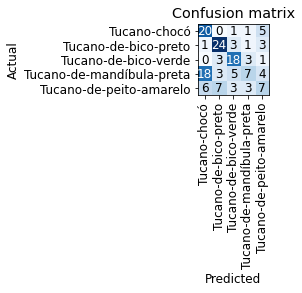

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

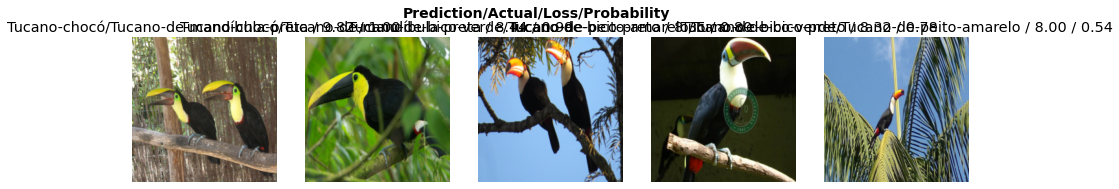

In [26]:
interp.plot_top_losses(5, nrows=1)

In [27]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [28]:
learn.export()

Let's check that the file exists, by using the `ls` method that fastai adds to Python's `Path` class:

In [29]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

You'll need this file wherever you deploy your app to. For now, let's try to create a simple app within our notebook.

When we use a model for getting predictions, instead of training, we call it *inference*. To create our inference learner from the exported file, we use `load_learner` (in this case, this isn't really necessary, since we already have a working `Learner` in our notebook; we're just doing it here so you can see the whole process end-to-end):

In [30]:
learn_inf = load_learner(path/'export.pkl')

In [34]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [35]:
dest = 'images/tucano.jpg'
download_url(ims[0], dest)

Path('images/tucano.jpg')

When we're doing inference, we're generally just getting predictions for one image at a time. To do this, pass a filename to `predict`:

In [36]:
learn_inf.predict('images/tucano.jpg')

('Tucano-de-mandíbula-preta',
 TensorBase(3),
 TensorBase([0.0056, 0.0290, 0.0217, 0.9286, 0.0151]))

This has returned three things: the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the *vocab* of the `DataLoaders`; that is, the stored list of all possible categories. At inference time, you can access the `DataLoaders` as an attribute of the `Learner`:

In [37]:
learn_inf.dls.vocab

['Tucano-chocó', 'Tucano-de-bico-preto', 'Tucano-de-bico-verde', 'Tucano-de-mandíbula-preta', 'Tucano-de-peito-amarelo']

In [50]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [51]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/tucano.jpg'])

In [52]:
img = PILImage.create(btn_upload.data[-1])

We can use an `Output` widget to display it:

In [53]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

<img alt="Output widget representing the image" width="117" src="images/att_00009.png">

Then we can get our predictions:

In [54]:
pred,pred_idx,probs = learn_inf.predict(img)

and use a `Label` to display them:

In [55]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Tucano-de-mandíbula-preta; Probability: 0.9286')

`Prediction: grizzly; Probability: 1.0000`

We'll need a button to do the classification. It looks exactly like the upload button:

In [56]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

We'll also need a *click event handler*; that is, a function that will be called when it's pressed. We can just copy over the lines of code from above:

In [57]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

You can test the button now by pressing it, and you should see the image and predictions update automatically!

We can now put them all in a vertical box (`VBox`) to complete our GUI:

In [58]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [60]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [61]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.7 MB 26.8 MB/s eta 0:00:01
     |████████████████████████████████| 397 kB 37.4 MB/s eta 0:00:01
     |████████████████████████████████| 558 kB 32.2 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 33.9 MB/s eta 0:00:01
     |████████████████████████████████| 71 kB 16.4 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 14.4 MB/s eta 0:00:01
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbdev 1.1.23 requires nbconvert<6, but you have nbconvert 6.4.2 which is incompatible.
Enabling: voila
- Writing config: /opt/conda/etc/jupyter
    - Validating...
      voila 0.3.1 OK
